# Introduction

## Explanation 1.1: Linear Programming

In the offline scenario, the total utility of the optimal task assignment, which is marked in red in TABLE 1, is 17.

|    | t1 | t2 | t3 | t4 | t5 | t6 |
|----|----|----|----|----|----|----|
| w1(1) |  7  |  1   |    |    |    |    |
| w2(3) |    |     |  1  |    |    |    |
| w3(2) |    |    |   9 |  1  |  1  |  1  |

In [1]:
from scipy.optimize import linprog
import numpy as np

c = -np.array([7, 1, 0, 0, 0, 0,
               0, 0, 1, 0, 0, 0,
               0, 0, 9, 1, 1, 1
               ])

A_ub = [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        ]

b_ub = [1, 3, 2, 1, 1, 1, 1, 1, 1]

bounds = [(0, 1) for _ in range(18)]

res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, integrality=1)

res.fun

-17.0

In [2]:
res.x

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.])

## Explanation 1.2: Global Online Micro-task Allocation

The GOMA problem, which generalizes the OMWBM problem, mainly differs from the OMWBM problem in that both the tasks and the workers are dynamic. 

| Timestamp | 0  | 1  | 2 | 7 | 8 | 9 | 9 | 15 | 18 |
|-----------|----|----|---|---|---|---|---|----|----|
| 1st order | t1 | t2 | w1  | w2  | t3  | t4  | w3  | t5   | t6   |
| 2nd order | w1 | t1   | t2  | t3  | w3  | t4  | w2  | t6   | t5   |

see Keynote.

# Problem Statement

Dataset Format Explanation:

| workerN/n | taskN/m  | Umax  | sumC |
|-----------|----|----|---|
| 817 | 4036 | 10.000000 | 4853  | 


| begTime | stype  | loc.first  | loc.second | endTime | cost.pay |
|-----------|----|----|---|----|---|
| 74875 | t | 1.790979 | 1.725669  |  600 | 3.6|


| begTime | stype  | loc.first  | loc.second | rad | cap | endTime | cost.rate |
|-----------|----|----|---|---|---|---|---|
| 444046 | w |1.230049 |1.007416 |1.000000| 1| 600 |0.597888|

In [3]:
from typing import Tuple
from abc import abstractmethod, ABCMeta
import os
import math
import random


class Vertex(metaclass=ABCMeta):
    """Either a task or a worker. """

    def __init__(self, arrival_time: int, location: Tuple[float], deadline: int, capacity: int) -> None:
        """Initialize a Vertex object."""
        assert len(location) == 2
        self.arrival_time = arrival_time
        self.location = location
        self.deadline = deadline
        # Without loss of generality, Say task also has capacity.
        # 1. The number of tasks assigned to a worker w cannot exceed his/her capacity cw.
        # 2. The number of workers assigned to a task t cannot exceed its capacity (1 here).
        self.capacity = capacity
        # 1. Number of tasks a Worker is assigned to (for Worker)
        # 2. Number of times a Task has been assigned (for Task), initially 0
        self.flow = 0

    def distance_from(self, v) -> float:
        """Calculate the Euclidean distance between self and another vertex. """
        return math.dist(self.location, v.location)

    @abstractmethod
    def utility_with(self, u):
        """The utility that a worker performs a task is measured by P_t * Delta_w.
        Without loss of generality, we will assume that utility is between 0 and U_max.
        """
        pass

    @abstractmethod
    def can_be_with(self, u):
        """Check the 4 constraints, namely:
        Invariable Constraint, Range Constraint, Deadline Constraint, Capacity Constraint
        """
        pass


class Worker(Vertex):
    """
    A worker that can perform tasks.

    A worker is a tuple <L, A, D, R, C, Delta>, who arrives at the initial location L in the 2D space, 
    at time A. He/She can perform several tasks that arrive at the platform before his/her response deadline D
    with several constraints:
    1. He/She can perform at most C tasks (i.e., his/her capacity); 
    2. He/She can only perform tasks posted within a circular range centered at L and with a radius of R;
    3. Delta is the success ratio based on his/her historical task completion records.
    """

    wid = 0

    def __init__(self, arrival_time: int, location: Tuple[float], radius: float, capacity: int, deadline: int, success_ratio: float) -> None:
        """Initializes a Worker object. """
        assert 0 < success_ratio <= 1
        super().__init__(arrival_time, location, deadline, capacity)
        self.radius = radius
        self.capacity = capacity
        self.success_ratio = success_ratio

        self.id = Worker.wid
        Worker.wid += 1

    def __str__(self) -> str:
        """Returns a string representation of the worker."""
        return f"w: loc = ({self.location[0]:.2f}, {self.location[1]:.2f}), rad = {self.radius:.2f}, cap = {self.capacity}, time = ({self.arrival_time}, {self.deadline}), success_ratio = {self.success_ratio:.2f}"

    def utility_with(self, task) -> float:
        return task.utility_with(self)

    def can_be_with(self, task) -> bool:
        return task.can_be_with(self)


class Task(Vertex):
    """
    A task that can be performed by a worker

    A task is a tuple <L, A, D, P>, which is posted at the location L in 2D space, at time A. 
    It can only be allocated to a worker who arrives before the response deadline D, with a payoff P.

    In the given dataset:
    A, D-A are an integer timestamp;
    L is composed by x, y float values;
    P is a float value.
    """

    tid = 0

    def __init__(self, arrival_time: int, location: Tuple[float], deadline: int, payoff: float) -> None:
        """Initializes a Task object. """
        super().__init__(arrival_time, location, deadline, capacity=1)
        self.payoff = payoff
        self.id = Task.tid
        Task.tid += 1

    def __str__(self) -> str:
        """Returns a string representation of the task."""
        return f"t: loc = ({self.location[0]:.2f}, {self.location[1]:.2f}), time = ({self.arrival_time}, {self.deadline}), payoff = {self.payoff:.2f}"

    def utility_with(self, worker: type[Worker]) -> float:
        return self.payoff * worker.success_ratio

    def can_be_with(self, worker: type[Worker]) -> bool:
        if self.flow > 0:
            return False

        if worker.distance_from(self) > worker.radius:
            return False

        if worker.arrival_time >= self.deadline or self.arrival_time >= worker.deadline:
            return False

        if worker.capacity <= worker.flow or self.capacity <= self.flow:
            return False

        return True


class GOMA:
    """
    Problem Parser.

    Given a set of tasks T, a set of workers W, and a utility function U (., .),
    the GOMA problem is to find an allocation M 
    to maximize the total utility such that the following constraints are satisfied:
    1. Deadline Constraint;
    2. Invariable Constraint;
    3. Capacity Constraint;
    4. Range Constraint.
    """

    def __init__(self, filepath: str = "../dataset/real/EverySender_cap1/data_00.txt"):
        assert os.path.exists(filepath)
        self.filepath = filepath
        self.workers: list[Worker] = []
        self.tasks: list[Task] = []
        Worker.wid = 0
        Task.tid = 0

        fin = open(file=self.filepath, mode='r')
        pieces = fin.readline().strip().split()
        self.num_worker = int(pieces[0])
        self.num_task = int(pieces[1])
        self.max_utility = float(pieces[2])
        self.sum_capacity = int(pieces[3])

        # used for algo2
        self.utility_matrix = np.zeros(
            (self.sum_capacity - self.num_task, self.num_task)
        )

    def update_matrix_for(self, v: type[Vertex]):
        if isinstance(v, Worker):
            self.utility_matrix[v.id, :len(self.tasks)] = [
                task.utility_with(v) if task.can_be_with(v) else 0 for task in self.tasks]
        elif isinstance(v, Task):
            self.utility_matrix[:len(self.workers), v.id] = [
                v.utility_with(worker) if v.can_be_with(worker) else 0 for worker in self.workers]
        else:
            raise TypeError

    def __iter__(self):
        """
        Iterates over the vertices (mimic the online scenario).

        Yields:
            Task: A task with attributes arrival_time, location, deadline, payoff, and radius.
            Worker: A worker with attributes arrival_time, location, capacity, deadline, and success_ratio.
        """
        fin = open(file=self.filepath, mode='r')
        # skip the header
        pieces = fin.readline().strip().split()

        for _ in range(self.num_worker + self.num_task):
            pieces = fin.readline().strip().split()
            args = {"arrival_time": int(pieces[0]),
                    "location": (float(pieces[2]), float(pieces[3]))}

            if pieces[1] == 't':
                args["deadline"] = int(
                    pieces[4]) + args["arrival_time"]
                args["payoff"] = float(pieces[5])
                task = Task(**args)
                self.tasks.append(task)
                self.update_matrix_for(task)
                yield task

            elif pieces[1] == 'w':
                args["radius"] = float(pieces[4])
                args["deadline"] = int(pieces[6]) + args["arrival_time"]
                args["success_ratio"] = float(pieces[7])

                # If a worker with capacity cw arrives,
                # Algorithm 1 regards him/her
                # as cw duplicates of w that arrive at the same time
                # and processes them one by one.
                args["capacity"] = 1
                for _ in range(int(pieces[5])):
                    worker = Worker(**args)
                    self.workers.append(worker)
                    self.update_matrix_for(worker)
                    yield worker

            else:
                raise StopIteration

# Algorithm1: Extended Greedy-RT

**Basic Idea**: first randomly choose a threshold on the weights of edges, 

and then *randomly* choose an edge incident to each newly arrived vertex among those edges whose weights are *no less than* the threshold.

In [4]:
class Algo:
    """
    Base class for solving GOMA algorithms. 
    Input: T, W
    """

    def __init__(self, problem: type[GOMA]) -> None:
        self.problem = problem
        self.total_utility = 0

    def append_to_match(self, u, v):
        """M := M \cup {(u, v)}"""
        self.total_utility += u.utility_with(v)
        u.flow += 1
        v.flow += 1

        # added for algo2
        self.problem.update_matrix_for(u)
        self.problem.update_matrix_for(v)


class Algo1(Algo):
    """ Algorithm 1. Extended Greedy-RT """

    def __init__(self, problem: type[GOMA]) -> None:
        super().__init__(problem)
        self.theta = int(math.ceil(math.log(self.problem.max_utility+1)))
        print(f"theta = {self.theta}")

    def select_threshold(self, k=-1):
        """Step 1: 
        theta := ceil(ln(U_max + 1)) [__init__]
            k := random drawn from {0, ..., theta - 1}

        n.b. for analysis, you may need to look at every possible value of k (say, when k is not -1)
        """
        if k < 0:
            k = random.randint(0, self.theta-1)

        print(f"k = {k}", end=", ")
        self.threshold = math.exp(k)

    def try_for_new_vertex(self, v: type[Vertex]):
        """Step 2 within the loop:
        foreach newly arrived vertex v dp
            cand := {u|u satisfies all the constraints and U(u, v) >= e^k}
            if cand is not empty then
                u* := an arbitrary item is chosen from cand
                m.append((u*, v))
        """
        assert isinstance(v, (Worker, Task))

        candidates = filter(
            lambda u:  u.can_be_with(
                v) and u.utility_with(v) >= self.threshold,
            self.problem.tasks if isinstance(
                v, Worker) else self.problem.workers
        )

        # if not self.randomness:
        #     pass
        # elif candidates := list(candidates):
        #     u = random.choice(candidates)

        u = None
        # filter() returns an iterator yielding those items
        for cand in candidates:
            u = cand
            break

        if u is not None:
            self.append_to_match(u, v)

    def run(self, k=-1) -> float:
        """
        1. select_threshold: randomly choose a threshold (ek) on the weights of edges according to the estimated maximum weight Umax;
        2. try_for_new_vertex: When a new vertex arrives, adds an edge among the ones whose weights are no less than a threshold and that satisfy all the constraints to the result;
        """
        self.total_utility = 0
        self.select_threshold(k)
        for v in self.problem:
            self.try_for_new_vertex(v)
        print("utility =", self.total_utility)
        self.problem = GOMA(self.problem.filepath)
        return self.total_utility

In [5]:
problem = GOMA("../dataset/synthetic/1000_2500_1_10_0.5_6_10/data_00.txt")
solver = Algo1(problem=problem)
for k in range(solver.theta):
    solver.run(k)

theta = 5
k = 0, utility = 4207.060537635773
k = 1, utility = 4504.4143007436105
k = 2, utility = 2050.1832838729138
k = 3, utility = 0
k = 4, utility = 0


# Algorithm2: TGOA

**Basic Idea**: Inspired by the solution to the *secretary problem*, our basic idea is to first divide all the vertices into two equal groups based on their arrival orders and adopt different strategies on them.

In [6]:
import numpy as np
from scipy.optimize import linear_sum_assignment


class Algo2(Algo):
    """ Algorithm 2. TGOA """

    def __init__(self, problem: type[GOMA]) -> None:
        super().__init__(problem)
        # k := [|T| + sum(c_w)] // 2
        self.median = self.problem.sum_capacity >> 1
        print(f"median = {self.median}")

    def phase_one(self, v):
        """ Phase 1: greedy strategy """

        matrix = self.problem.utility_matrix
        us = self.problem.tasks
        if isinstance(v, Task):
            matrix = matrix.T
            us = self.problem.workers

        # with the maximum utility
        idx = np.argmax(matrix[v.id, :])

        # satisfying all the constraints
        if matrix[v.id, idx] != 0:
            u = us[idx]
            self.append_to_match(u, v)

    def phase_two(self, v):
        """ Phase 2: more optimal strategy """

        matrix = self.problem.utility_matrix
        us = self.problem.tasks
        if isinstance(v, Task):
            matrix = matrix.T
            us = self.problem.workers

        # Hungarian algorithm (Jonker–Volgenant implementation)
        row_idx, col_idx = linear_sum_assignment(matrix, True)
        if v.id == row_idx[-1]:
            if col_idx[-1] <= len(us):
                u = us[col_idx[-1]]
                self.append_to_match(u, v)

    def try_for_new_vertex(self, v: type[Vertex]):
        """Procedure within the FOREACH. """

        # Phase 1: greedy strategy
        if len(self.problem.tasks) + len(self.problem.workers) < self.median:
            self.phase_one(v)

        # Phase 2: more optimal strategy
        else:
            self.phase_two(v)

    def run(self) -> float:
        self.total_utility = 0
        for v in self.problem:
            self.try_for_new_vertex(v)
        print("utility =", self.total_utility)
        return self.total_utility

In [7]:
import cProfile
import pstats

with cProfile.Profile() as pf:
    problem = GOMA("../dataset/synthetic/1000_2500_1_10_0.5_6_10/data_00.txt")
    solver = Algo2(problem=problem)
    solver.run()

stats = pstats.Stats(pf)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats(filename='algo2.prof')

median = 1750
utility = 4177.855989302226


# Algorithm3: TGOA-Greedy



In [8]:
class Algo3(Algo2):
    """ Algorithm 3. TGOA-Greedy Algorithm 
    We replace the Hungarian algorithm with the greedy strategy.
    """

    def phase_two(self, v):
        """ Greedy-Match """

        matrix = self.problem.utility_matrix
        while True:
            # a feasible pair of (w, t) with the highest utility that is unmatched
            row_idx, col_idx = np.unravel_index(matrix.argmax(), matrix.shape)

            # if (w, t) exists
            if matrix[row_idx,  col_idx] != 0:
                self.append_to_match(
                    self.problem.workers[row_idx], self.problem.tasks[col_idx])

            else:
                break

In [9]:

with cProfile.Profile() as pf:
    problem = GOMA("../dataset/synthetic/1000_2500_1_10_0.5_6_10/data_00.txt")
    solver = Algo3(problem=problem)
    solver.run()

stats = pstats.Stats(pf)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats(filename='algo3.prof')

median = 1750
utility = 4193.171309202554


# Algorithm4: TGOA-OP

keep removing the tasks and workers whose deadlines have passed

In [10]:
class Algo4(Algo3):
    """ Algorithm 3. TGOA-OP Algorithm 
    The basic idea of TGOA-OP is to keep removing the tasks and workers whose deadlines have passed, 
    such that the number of available task and workers is much smaller than the total number of tasks and workers.
    """

    def __init__(self, problem: type[GOMA]) -> None:
        super().__init__(problem)

        old_update_matrix_for = problem.update_matrix_for

        def revisited_update_matrix_for(v):
            old_update_matrix_for(v)
            # removing the tasks whose deadline has passed
            for tid in range(len(problem.tasks)):
                if problem.tasks[tid].deadline < v.arrival_time:
                    problem.utility_matrix[:, tid] = 0

            # removing the workers whose deadline has passed
            for wid in range(len(problem.workers)):
                if problem.workers[wid].deadline < v.arrival_time:
                    problem.utility_matrix[wid, :] = 0

        problem.update_matrix_for = revisited_update_matrix_for

In [11]:
with cProfile.Profile() as pf:
    problem = GOMA("../dataset/synthetic/1000_2500_1_10_0.5_6_10/data_00.txt")
    solver = Algo4(problem=problem)
    solver.run()

stats = pstats.Stats(pf)
stats.sort_stats(pstats.SortKey.TIME)
stats.dump_stats(filename='algo4.prof')

median = 1750
utility = 4193.171309202554


# Experiment Results

ref: https://seaborn.pydata.org/tutorial/properties.html

In [15]:
import pandas as pd

data = {
    'algo': [],
    'w': [],
    't': [],
    'utility': [],
}

for i in range(4):
    for root, dirs, files in os.walk("../dataset/synthetic/"):
        for file in files:
            if file.endswith(".txt"):
                filepath = os.path.join(root, file)
                problem = GOMA(filepath)
                solver = eval(f"Algo{i+1}(problem=problem)")

                data['algo'].append(i+1)
                data['w'].append(problem.sum_capacity - problem.num_task)
                data['t'].append(problem.num_task)
                data['utility'].append(solver.run())

df = pd.DataFrame(data=data)
df.to_pickle("main.pkl")

theta = 5
k = 3, utility = 0
theta = 5
k = 3, utility = 0
theta = 5
k = 1, utility = 2752.211386080683
theta = 5
k = 4, utility = 0
theta = 5
k = 1, utility = 3735.757639828117
theta = 5
k = 4, utility = 0
theta = 5
k = 0, utility = 2523.9562416731046
theta = 5
k = 3, utility = 0
theta = 5
k = 3, utility = 0
theta = 5
k = 1, utility = 61.587083305560995
theta = 5
k = 2, utility = 2549.146324865423
theta = 5
k = 1, utility = 2760.4959912099443
theta = 5
k = 3, utility = 0
theta = 5
k = 3, utility = 0
theta = 5
k = 0, utility = 1295.058314060325
theta = 5
k = 0, utility = 12415.316600854054
theta = 5
k = 4, utility = 0
theta = 5
k = 4, utility = 0
theta = 5
k = 2, utility = 1858.4829648316822
theta = 5
k = 1, utility = 1802.2094321511943
theta = 5
k = 3, utility = 0
theta = 5
k = 2, utility = 4981.849436777882
theta = 5
k = 2, utility = 0
theta = 5
k = 3, utility = 12120.70478321639
theta = 5
k = 4, utility = 0
theta = 5
k = 1, utility = 0
theta = 5
k = 3, utility = 0
theta = 5
k = 2, ut

In [39]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

plt.style.use(['fivethirtyeight', 'science', 'grid'])
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")
sns.set_palette("RdBu")
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)

df = pd.read_pickle('main.pkl')

In [40]:
df

,algo,w,t,utility
0,1,500,2500,0.000000
1,1,500,2500,0.000000
2,1,500,2500,2752.211386
3,1,500,2500,0.000000
4,1,500,2500,3735.757640
...,...,...,...,...
151,4,500,2500,2563.730376
152,4,500,2500,4635.563471
153,4,500,2500,63.706998
154,4,500,2500,2576.829115


/Users/durui/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/durui/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/durui/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/durui/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

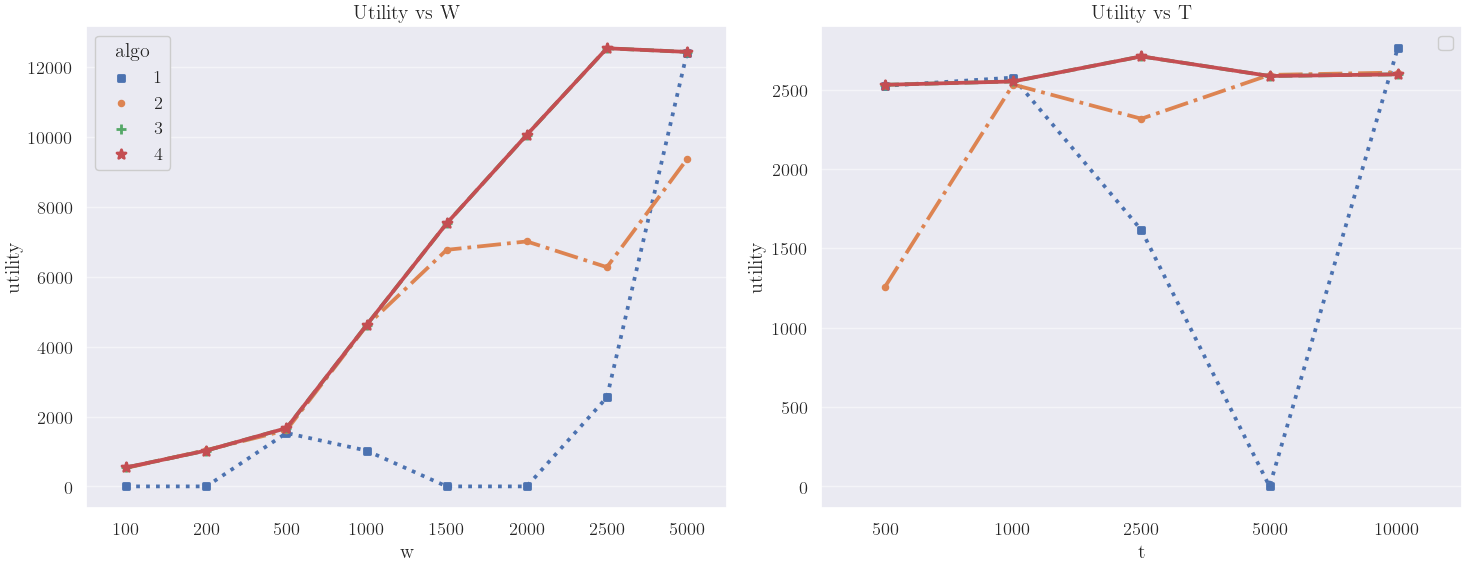

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.pointplot(data=df, x='w', y='utility', hue='algo', ax=axes[0], errorbar=None,
              markers=[(4, 0, 45), '.', '+', '*'],
              linestyles=['dotted', 'dashdot', 'dashed', 'solid'])
sns.pointplot(data=df, x='t', y='utility', hue='algo', ax=axes[1], errorbar=None,
              markers=[(4, 0, 45), '.', '+', '*'],
              linestyles=['dotted', 'dashdot', 'dashed', 'solid'])

axes[1].legend('')
axes[0].set_title('Utility vs W')
axes[1].set_title('Utility vs T')
plt.tight_layout()
plt.savefig("main.pdf", format='pdf')